# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [2]:
import numpy as np
from scipy import optimize
import scipy.optimize as opt
import sympy as sm
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Model description


**1) The Fischer Equation**:

$$
r = i-\pi^{e}_{+1}
$$

**2) The general market equilibrium (GME)**

$$
y-\bar{y} = \alpha_1 (g-\bar{g}) - \alpha_2(r-\bar{r})
$$

**3) The Taylor Rule**

$$
i = \bar{r} + \pi^{e}_{+1} + h(\pi - \pi^*) + b(y- \bar{y})
$$

**4) The SRAS curve** which is derived from the Expectations-Augmented Phillips Curve

$$
\pi = \pi^e + \gamma (y-\bar{y}) + s
$$


**5) Assuming static, backwards-looking inflation expectations in the economy**

$$
\pi^e = \pi_{-1}
$$


## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

In [22]:
#Defining all symbols
real_int = sm.symbols('r')
structural_real_int = sm.symbols(r'\overline{r}')
nominal_int = sm.symbols('i')
outputgab = sm.symbols(r'(y-\overline{y})')
structural_output = sm.symbols(r'(\overline{y})')
output = sm.symbols('y')
alpha_1 = sm.symbols('alpha_1')
alpha_2 = sm.symbols('alpha_2')
gov = sm.symbols('g')
structural_gov = sm.symbols(r'\overline{g}')
h = sm.symbols('h')
b = sm.symbols('b')
inflation = sm.symbols('\pi')
exp_inf_t_plus_one = sm.symbols('\pi_{t+1}^e')
inf_t_minus_one = sm.symbols('\pi_{t-1}')
inflation_target = sm.symbols('\pi^*')
gamma = sm.symbols('\gamma')
s = sm.symbols('s')


#Setting the symbols to be read as unicode
sm.init_printing(use_unicode=True)







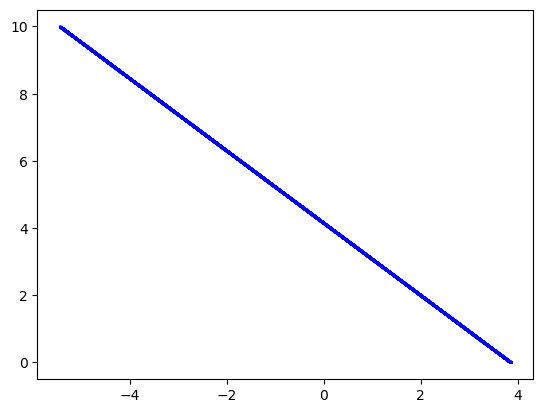

In [23]:
#Using the Taylor, Fischer and GME to solve for the AD curve.
taylor = structural_real_int+exp_inf_t_plus_one+h*(inflation-inflation_target)+b*(outputgab)
fischer = taylor - exp_inf_t_plus_one
outputgab_solve = sm.Eq(outputgab,alpha_1*(gov-structural_gov)-alpha_2*(fischer-structural_real_int))


AD = sm.solve(outputgab_solve,outputgab)[0]+structural_output

#Defining the AS-curve
AS = inf_t_minus_one+gamma*(outputgab)+s


# Lambdify the AD curve

AD_function = sm.lambdify((structural_output,structural_gov,alpha_1, alpha_2, inflation, inflation_target, h, b, gov),AD)

inflation_values = np.linspace(0,10,10000)

 

output_values = []
for inflation in inflation_values:
    #Assumptions
    y_bar,g_bar,alpha1, alpha2, pi_target, H, B, g = 2, 2, 1.2, 0.9, 2, 1.5, 0.5, 2
    y = AD_function(y_bar,g_bar,alpha1, alpha2, inflation,pi_target, H, B, g)
    output_values.append(y)

plt.scatter(output_values,inflation_values, s=1, color='blue')

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 